In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import r2_score as r2

import xgboost as xgb
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score
import seaborn as sns

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете

In [2]:
path_train = ('./course_project_train.csv')
path_test = ('./course_project_test.csv')

## Функции 

In [3]:
# собираю категориальные признаки
def qualitative_columns(df):
    qualitative_columns=[]
    for col in df.select_dtypes(include=object):
        qualitative_columns.append(col)
#         print (col,'\n',df[col].value_counts(),'\n')
    return qualitative_columns


# собираю количественные признаки
def quantity_columns(df):
    quantity_columns=[]
    for col in df.select_dtypes(exclude=object):
        quantity_columns.append(col)
#         print (col,'\n',df[col].value_counts(),'\n')
    return quantity_columns

In [4]:
# сравнение  распределения у теста и трени
def boxplot(feature, df_train, df_test):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
    fig.tight_layout(pad=4.0)
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    sns.boxplot(y=feature, data=df_train, orient="h",  ax=ax[0])
    sns.boxplot(y=feature, data=df_test, orient="h",  ax=ax[1])
    plt.show()

In [5]:
# замена категориальных в числовые
def replace_quantitives(df):
    quantitative_cols=[]
    qualitative_columns=[]
    quantitative_cols = [col for col in df.columns if df[col].dtype != 'object']
    qualitative_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # для редактирования
#     quantitative_cols.remove('Id') # удал - ненужный параметр
    
    # замены
    df['Years in current job'] = df['Years in current job'].replace({'10+ years':10,
                                                                     '8 years':8,
                                                                     '7 years':7,
                                                                    '6 years':6,
                                                                    '5 years':5,
                                                                    '4 years':4,
                                                                     '3 years':3,
                                                                     '2 years':2,
                                                                     '1 years':1,
                                                                     '< 1 year':0,
                                                                    })
    
    quantitative_cols = [col for col in train_df.columns if train_df[col].dtype != 'object']
    
    return df

# train_df = replace_quantitives(train_df)
# test_df = replace_quantitives(test_df)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Таблица с тестами на предикт**

In [7]:
results = pd.DataFrame(columns=[
    'Model', 
    'F1', 
    'Accuracy', 
    'Precision', 
    'Recall', 
    'Best F1 Train', 
    'Best Params', 
    'Constant Params'
])

In [8]:
def GridSearch(model_name, model, X, y, const_params, hyper_params):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.25, 
        shuffle=True,
        random_state=21
    )
    
    result = {'Model': model_name}
    
    grid = GridSearchCV(
        estimator=model(**const_params),
        param_grid=hyper_params,
        scoring='f1',
        n_jobs=-1,
        cv=KFold(
            n_splits=5, 
            shuffle=True, 
            random_state=21
        )
    )
    
    grid.fit(X_train, y_train)
    
    result['Best Params'] = grid.best_params_
    result['Constant Params'] = const_params
    result['Best F1 Train'] = grid.best_score_
    
    best_model = model(**grid.best_params_, **const_params)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    result['F1'] = f1_score(y_test, y_pred)
    result['Accuracy'] = accuracy_score(y_test, y_pred)
    result['Precision'] = precision_score(y_test, y_pred)
    result['Recall'] = recall_score(y_test, y_pred)
    
    return result

## Обзор датасета

In [9]:
df = pd.read_csv(path_train)
df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_test = pd.read_csv(path_test)
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [13]:
target = 'Credit Default'
df[target].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [14]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


**Выбросы**

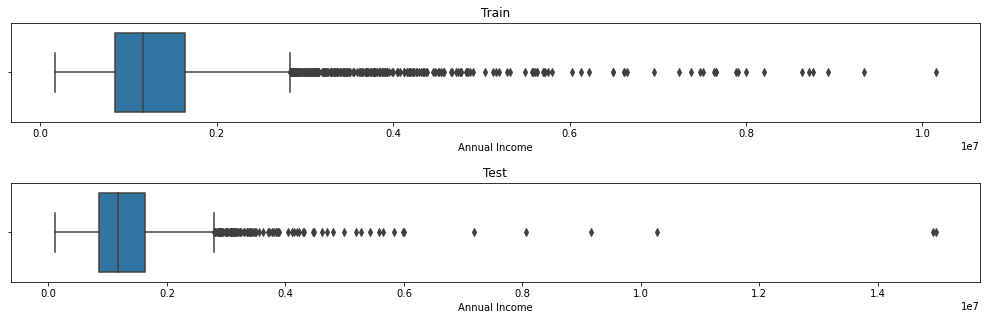

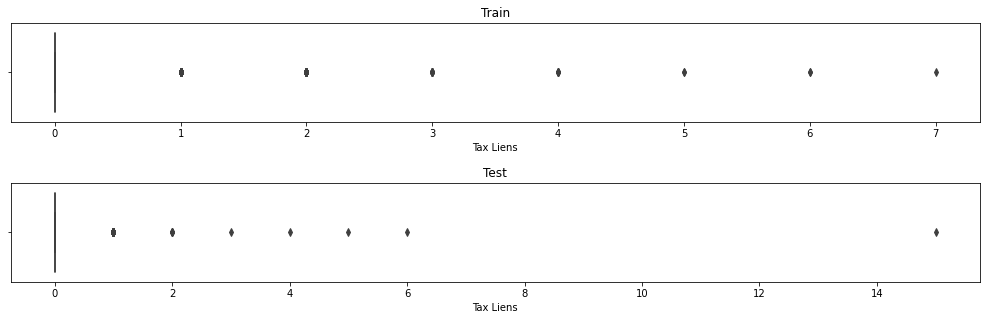

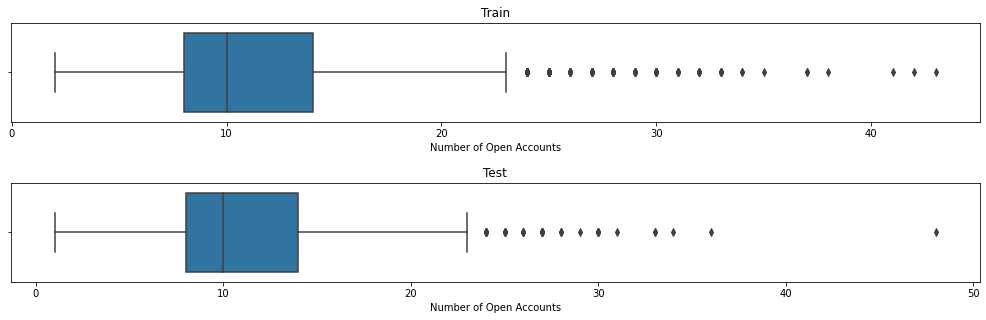

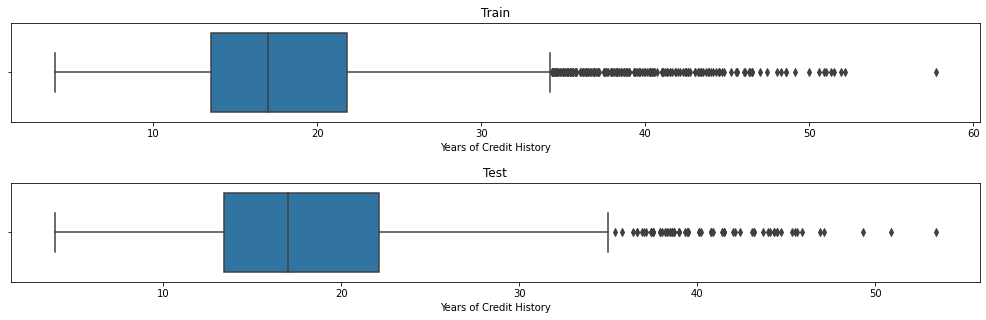

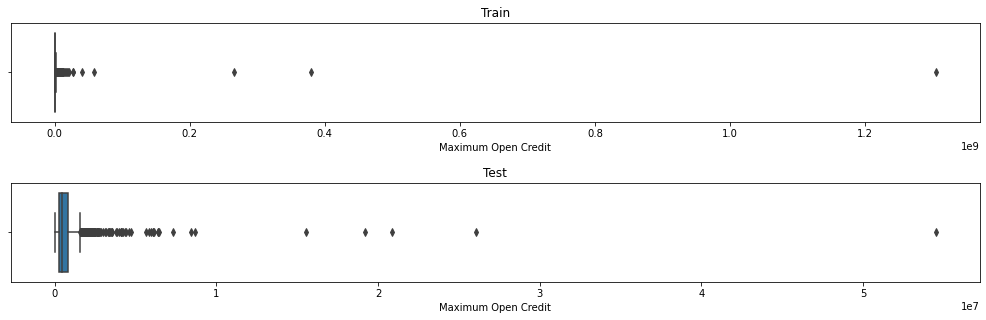

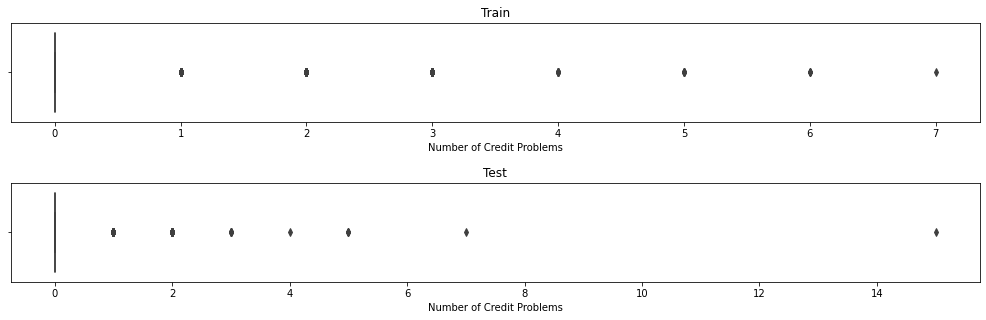

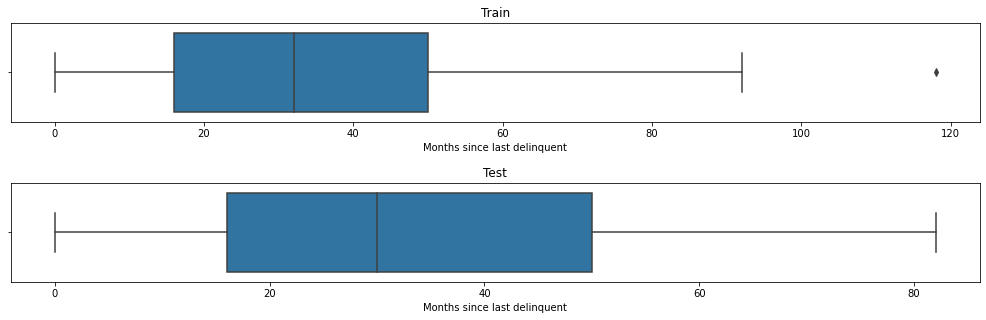

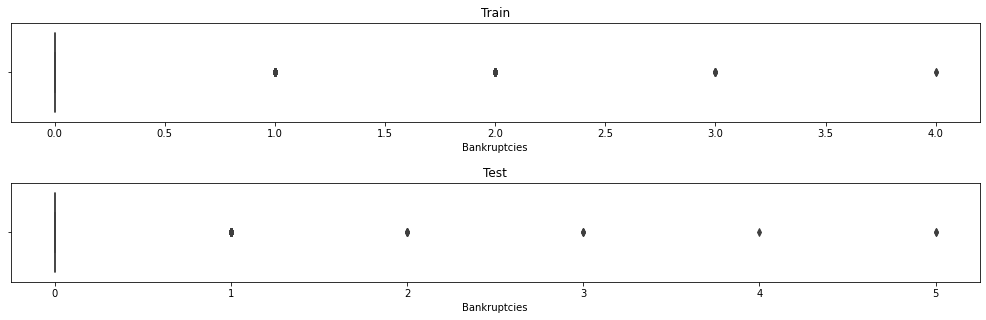

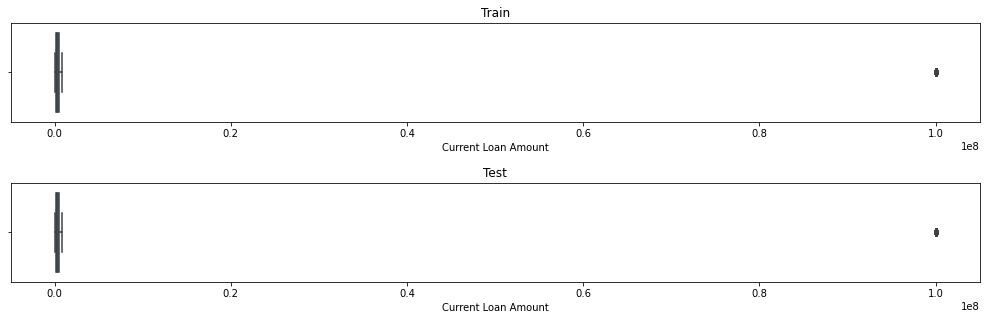

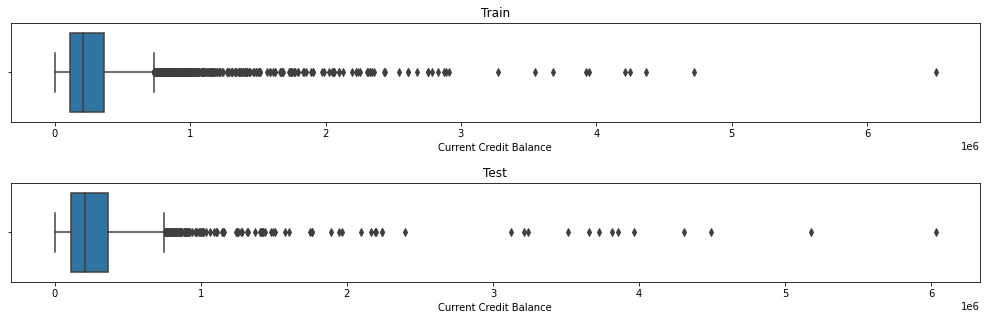

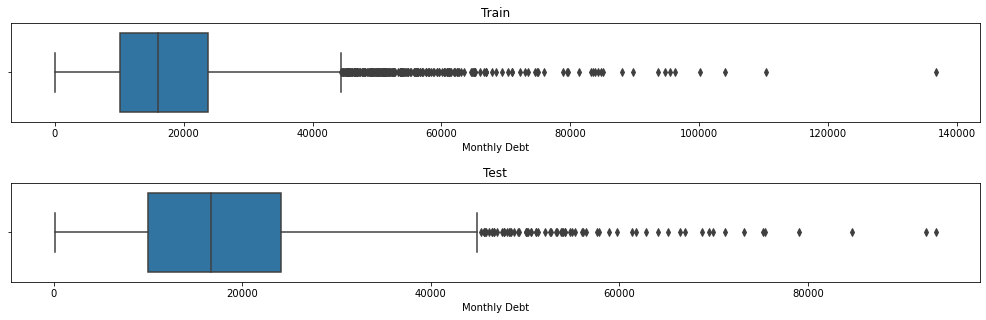

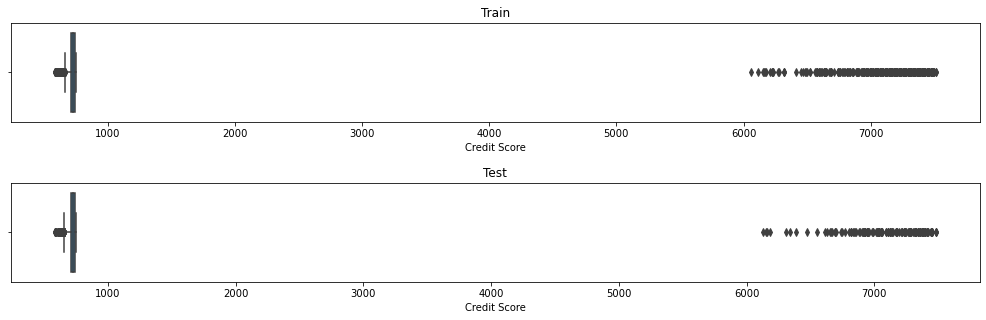

In [16]:
columns = quantity_columns(df_test)
for i in columns:
    boxplot(i, df, df_test)

In [17]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [18]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [19]:
# кредитный рейтинг 400 элементов показывает почти в 10 раз выше нормы (попробую разделить на 10 чтобы усреднить)
df_cred = df['Credit Score'] > 1000
df[df_cred]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


In [20]:
m = df['Months since last delinquent'] > 100
df[m]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4191,Home Mortgage,3009201.0,6 years,0.0,10.0,20.8,773322.0,0.0,118.0,0.0,debt consolidation,Short Term,449592.0,299877.0,15297.0,738.0,0


**Замены**

In [21]:
def changeValues(df):
    # поменяю значние кажется заполняли по какому то шаблону
    df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
    
    df.loc[df['Credit Score'] > 1000, 'Credit Score']  /= 10
    df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score']  /= 10
    return df

df = changeValues(df)

**Пропуски**

In [22]:
n = len(df) - df.count()
nuls = n[n !=0]
nuls

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

In [23]:
df[df['Credit Score'].isnull()].head(20)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
23,Own Home,NaN,10+ years,0.0,17.0,14.8,700040.0,0.0,17.0,0.0,debt consolidation,Short Term,174878.0,168074.0,17132.0,NaN,1
24,Own Home,NaN,NaN,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,NaN,0
29,Rent,NaN,10+ years,0.0,9.0,18.6,186494.0,0.0,6.0,0.0,debt consolidation,Short Term,357918.0,72808.0,22352.0,NaN,1
33,Home Mortgage,NaN,< 1 year,0.0,13.0,21.0,101464.0,0.0,11.0,0.0,other,Short Term,79464.0,60287.0,14003.0,NaN,1
35,Rent,NaN,< 1 year,0.0,9.0,31.4,1457104.0,0.0,32.0,0.0,buy a car,Short Term,155474.0,254201.0,7020.0,NaN,0


In [24]:
def fillNulls(df):
    # заполню зарплату минимальным значением
    m = df['Annual Income'].min()
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = m
    
    # заполню самым популярным значением
    mode = df['Years in current job'].mode()
    df['Years in current job'].fillna(value=mode, inplace=True)

    m = df['Months since last delinquent'].min()
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = m
    
    n = df['Bankruptcies'].isnull()
    median = df['Bankruptcies'].median()
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = median
    return df 

    
df = fillNulls(df)

In [25]:
def fillCreditScore(df):
    a=df['Number of Credit Problems'] > 0
    b=df['Months since last delinquent']  > 0
    c=df['Bankruptcies'] > 0
    median = df[a | b | c]['Credit Score'].median()
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = median
    return df

df = fillCreditScore(df)

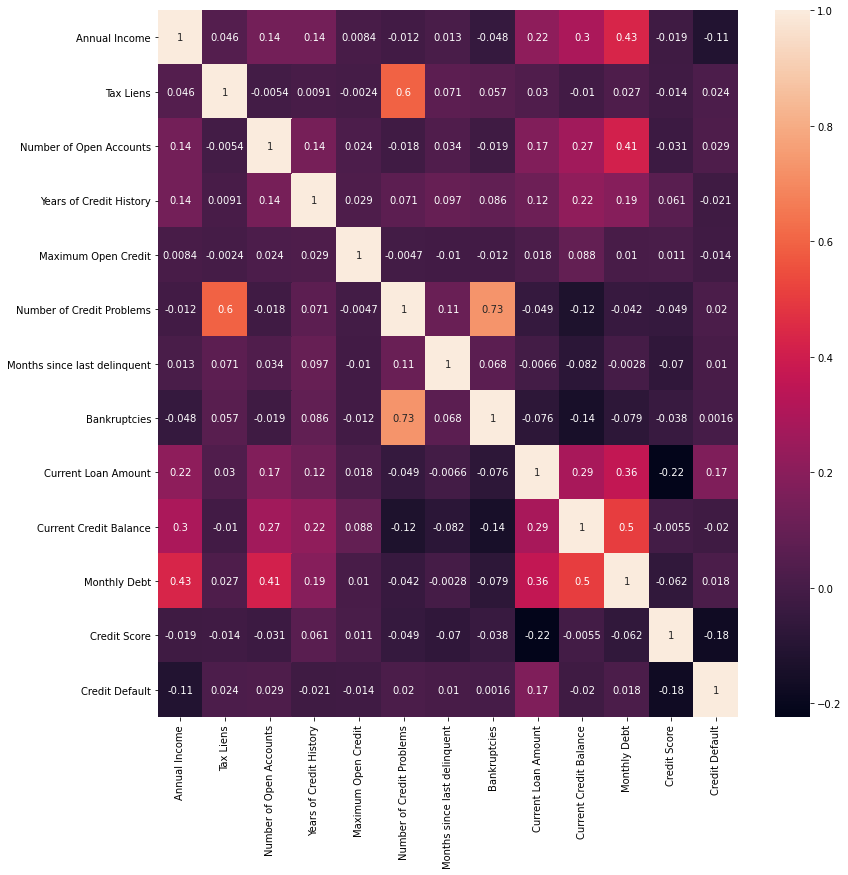

In [26]:
plt.figure(figsize=(13, 13))
sns.heatmap(df.corr(), annot=True)
plt.show()

**Обработка категорий**

In [27]:
qual_cat = qualitative_columns(df)

for c in qual_cat:
    print(c, '\n', df[c].unique())

Home Ownership 
 ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
Years in current job 
 ['10+ years' '8 years' '6 years' '7 years' '5 years' '1 year' '< 1 year'
 '4 years' '3 years' '2 years' nan '9 years']
Purpose 
 ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']
Term 
 ['Short Term' 'Long Term']


In [28]:
def makeOnlyQualitative(df):
    df_train_cat = pd.get_dummies(df, drop_first=True)

    # удаляю категории из датасета и добавлю количественные
    qual_cat = qualitative_columns(df)

    df = df.drop(qual_cat, axis=1,  errors='ignore')

    quan_cat = quantity_columns(df_train_cat)
    for cat in quan_cat:
        df[cat] = df_train_cat[cat]
        
    #В форесте ругается на знак < в названии - меняю
    df = df.rename(columns={'Years in current job_< 1 year': 'Years in current job_01year'})
    
    #в тестовом сете нет параметра Purpose_renewable energy, удаляю из трени
    df = df.drop(columns='Purpose_renewable energy',  errors='ignore')   
    return df


df = makeOnlyQualitative(df)

**Анализ признаков**

Вес признака

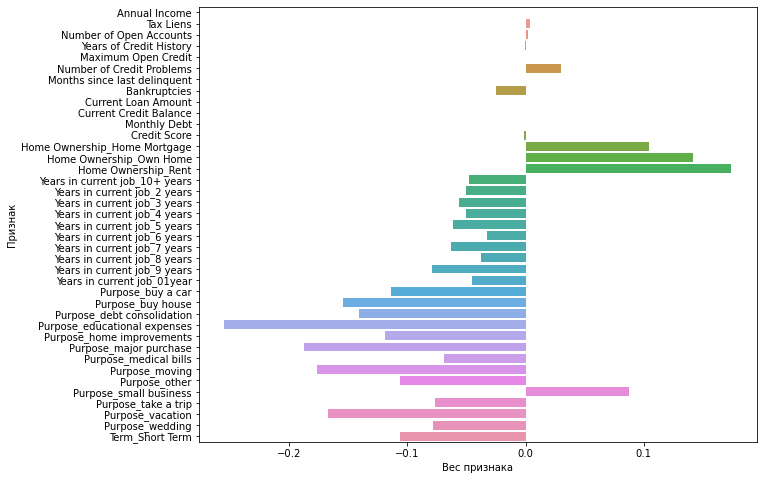

In [29]:
X = df.drop('Credit Default', axis=1)
y = df['Credit Default']

# X = df.drop('Years in current job_< 1 year', axis=1)

scaler = StandardScaler()
lr = LinearRegression()

scaler.fit_transform(X)
lr.fit(X, y)

plt.figure(figsize =(10, 8))

sns.barplot(x=lr.coef_.flatten(), y = X.columns)

plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

Корреляция с целевой переменной

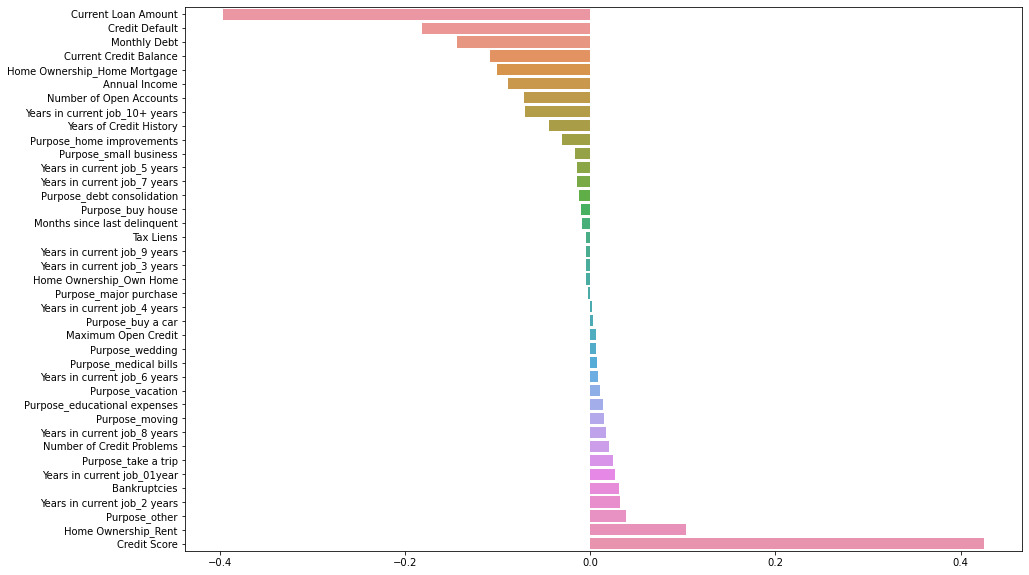

In [30]:
cor = df.corr().iloc[:-1, -1].sort_values()
plt.figure(figsize=(15, 10))
sns.barplot(x=cor.values, y=cor.index)

plt.show()

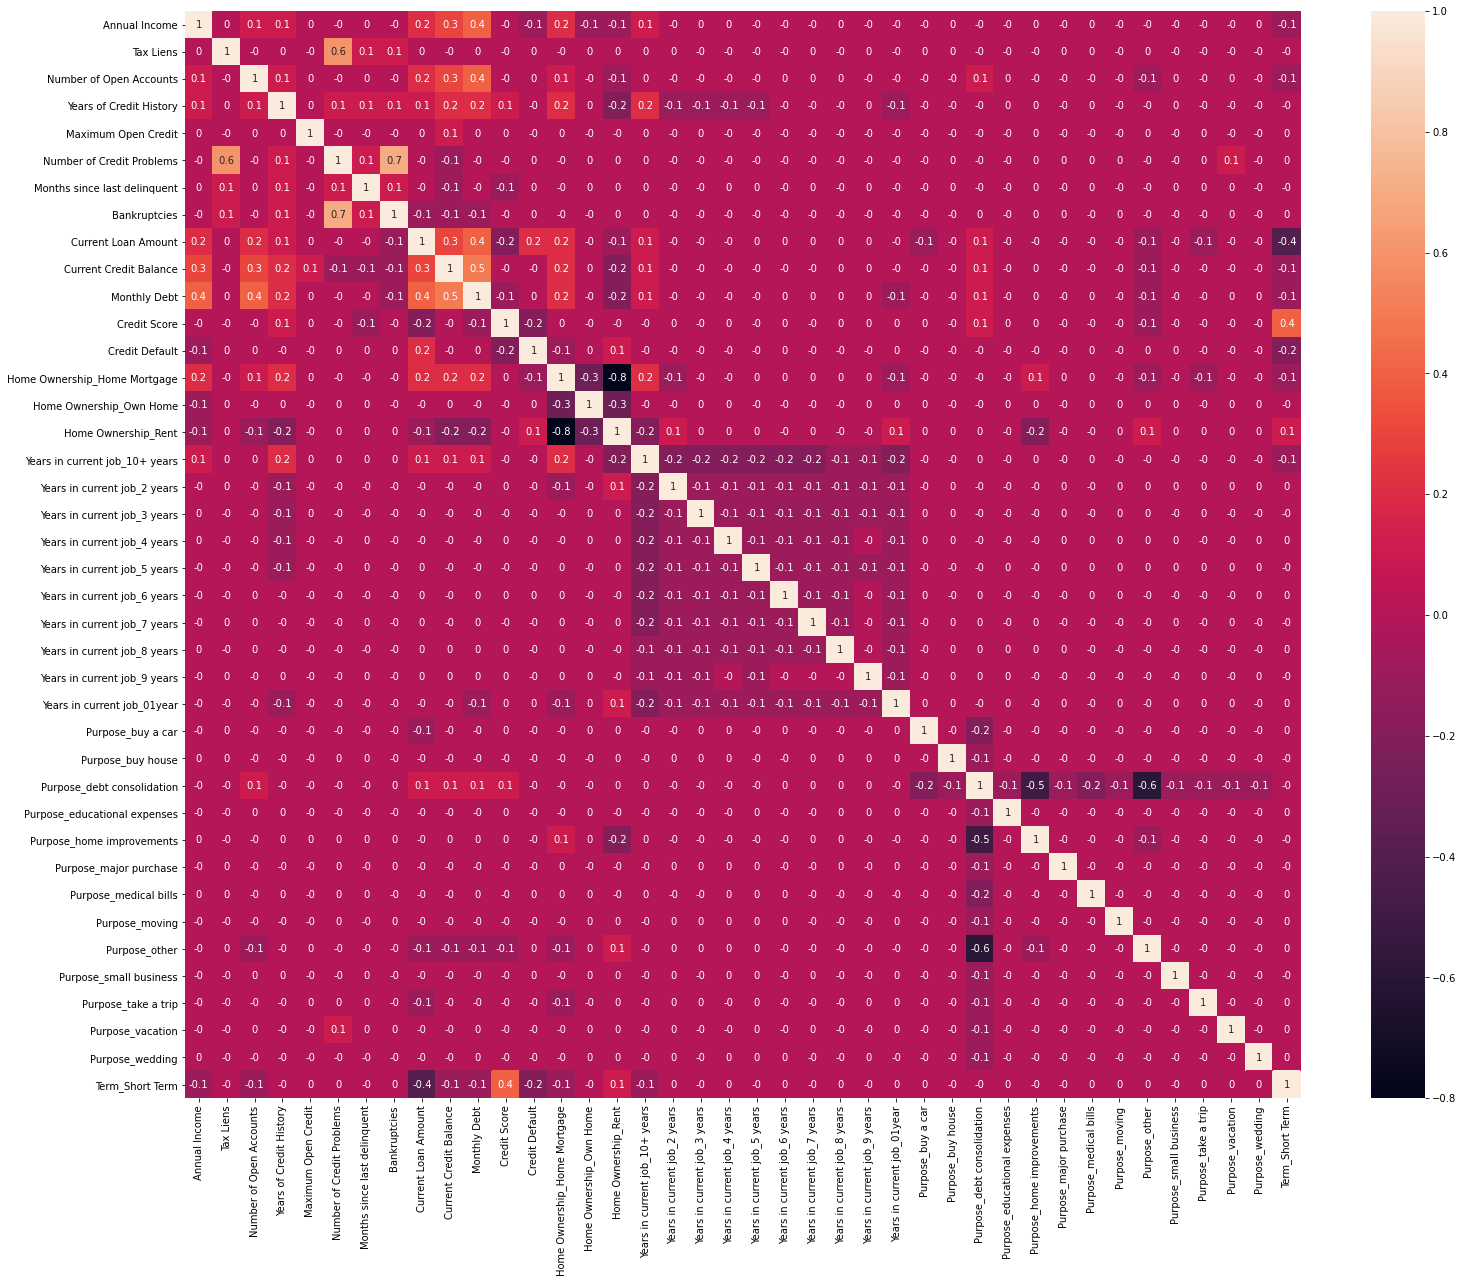

In [31]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr().round(1), annot=True)
plt.show()

In [32]:
cor = df.corr().iloc[:-1, -1].sort_values(ascending=False)
cor.index

Index(['Credit Score', 'Home Ownership_Rent', 'Purpose_other',
       'Years in current job_2 years', 'Bankruptcies',
       'Years in current job_01year', 'Purpose_take a trip',
       'Number of Credit Problems', 'Years in current job_8 years',
       'Purpose_moving', 'Purpose_educational expenses', 'Purpose_vacation',
       'Years in current job_6 years', 'Purpose_medical bills',
       'Purpose_wedding', 'Maximum Open Credit', 'Purpose_buy a car',
       'Years in current job_4 years', 'Purpose_major purchase',
       'Home Ownership_Own Home', 'Years in current job_3 years',
       'Years in current job_9 years', 'Tax Liens',
       'Months since last delinquent', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Years in current job_7 years',
       'Years in current job_5 years', 'Purpose_small business',
       'Purpose_home improvements', 'Years of Credit History',
       'Years in current job_10+ years', 'Number of Open Accounts',
       'Annual Income', 'Home Owne

### Обучение

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [34]:
%%time
const_params = {
    'class_weight': 'balanced',
    'random_state': 21,
    'n_jobs': -1
}

hyper_params = {
    'n_estimators': np.arange(30,250,50),
    'learning_rate': np.arange(0.01, 0.07, 0.01),
    'max_depth': np.arange(3,7,1),
    'num_leaves': np.arange(100, 401,100)
}

result = GridSearch(
    'LightBoost',
    LGBMClassifier,
    X,
    y,
    const_params,
    hyper_params
)

print('best ', result)
results = results.append(result, ignore_index=True)

best  {'Model': 'LightBoost', 'Best Params': {'learning_rate': 0.060000000000000005, 'max_depth': 5, 'n_estimators': 30, 'num_leaves': 100}, 'Constant Params': {'class_weight': 'balanced', 'random_state': 21, 'n_jobs': -1}, 'Best F1 Train': 0.5112671363046101, 'F1': 0.5045871559633028, 'Accuracy': 0.5968, 'Precision': 0.38810483870967744, 'Recall': 0.7209737827715356}
CPU times: user 7.8 s, sys: 1.23 s, total: 9.03 s
Wall time: 1min 50s


In [36]:
results

,Model,F1,Accuracy,Precision,Recall,Best F1 Train,Best Params,Constant Params
0,LightBoost,0.504587,0.596800,0.388105,0.720974,0.511267,"{'learning_rate': 0.060000000000000005, 'max_d...","{'class_weight': 'balanced', 'random_state': 2..."
1,XGBClassifier,0.307298,0.711467,0.485830,0.224719,0.336055,"{'base_score': 0.4000000000000001, 'learning_r...",{'random_state': 21}


In [37]:
# model_xgb = LGBMClassifier(n_estimators=80, num_leaves=100, random_state=21, base_score=0.3, learning_rate=0.05, max_depth=3)
# model_xgb.fit(X_train, y_train)

# y_train_pred = model_xgb.predict(X_train)
# y_test_pred = model_xgb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Predict on real

**Prepare real dataset**

In [38]:
df_test_tmp = changeValues(df_test)
df_test_tmp = fillNulls(df_test)
df_test_tmp = fillCreditScore(df_test)
df_test_tmp = makeOnlyQualitative(df_test)

**Predict real dataset** 

In [39]:
model_name = 'LightBoost'
model = LGBMClassifier

best_params = list(results.loc[results['Model'] == model_name, 'Best Params'])[0]
const_params = list(results.loc[results['Model'] == model_name, 'Constant Params'])[0]

best_model = model(**best_params, **const_params)
best_model.fit(X, y)


y_pred = best_model.predict(df_test_tmp)
                            

predict = pd.DataFrame()
predict['Credit Default'] = y_pred

result = pd.concat([df_test, predict], axis=1)
result

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,106533.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,724.0,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,1
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,0.0,162735.0,15046.0,745.0,0
2496,Home Mortgage,106533.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,724.0,0
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,1
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,1


In [40]:
result['Credit Default'].sum()

1304

**save csv**

In [ ]:
result.to_csv('RKurnovskii_predict.csv', index=None, header=False)